# Relax Challenge

Greg Welliver   

In [1]:
# Import relevant libraries and packages.
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.ticker as plticker
import seaborn as sns
sns.set()
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn import linear_model, preprocessing 
import warnings
from scipy import stats
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import lightgbm as lgb
from lightgbm import LGBMRegressor
from numpy import mean
from numpy import std
from functools import partial
%matplotlib inline
from sklearn.linear_model import GammaRegressor
from sklearn.linear_model import TweedieRegressor

import statsmodels.api as sm
from statsmodels.graphics.api import abline_plot
from scipy import stats

from sklearn.datasets import fetch_openml
from sklearn import linear_model, preprocessing, tree, svm, datasets, metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, auc, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score, f1_score, log_loss
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import xgboost
from xgboost import XGBClassifier
from xgboost import XGBRegressor
import lightgbm as lgb
from lightgbm import LGBMClassifier


from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder as OHE
import sklearn.model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_tweedie_deviance, make_scorer


import xgboost
from xgboost import XGBClassifier
from xgboost import XGBRegressor
import warnings
from subprocess import call
from IPython.display import Image
from datetime import datetime, timedelta, date
import os
import plotly.graph_objects as go
import itertools
from io import StringIO  
import pydotplus

# Seaborn settings
sns.set_context('notebook')
#sns.set_style("whitegrid")
#sns.set_style("white")
style_set = sns.set_style('whitegrid')
pd.options.display.float_format = '{:,}'.format
color_choice1 = 'plum'
color_choice2 = 'lightblue'
color_choice3 = 'lightgreen'
color_choice4 = 'blue'
#ax.yaxis.set_major_formatter('{x:,.0f}')
#sns.set_context('notebook', font_scale = 4)

#from mpl_toolkits.basemap import Basemap
import geopandas as gpd
from shapely.geometry import Point, Polygon
import contextily as ctx

from sklearn.feature_extraction.text import CountVectorizer
import json
from ydata_profiling import ProfileReport
import calendar


## <font color='orange'>Load the data</font>



In [2]:
# load data
dfue = pd.read_csv("takehome_user_engagement.csv")
dfu = pd.read_csv("takehome_users.csv", encoding='latin-1')
#df = pd.read_csv("../Data/StormEvents_details-ftp_v1.0_d2001_c20220425.csv")

In [3]:
dfue.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [4]:
dfu.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,"1,398,138,810.0",1,0,11,"10,803.0"
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,"1,396,237,504.0",0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,"1,363,734,892.0",0,0,94,"1,525.0"
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,"1,369,210,168.0",0,0,1,"5,151.0"
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,"1,358,849,660.0",0,0,193,"5,240.0"


profile = ProfileReport(dfue)
profile

profile = ProfileReport(dfu)
profile

## <font color='orange'>Data Quality Observations</font>
- takehome_user_engagement.csv appears to be a clean dataset - no missing values, no duplicates
- takehome_users.csv has 8760 missing values - 7.3%. We'll need to address those. The missing values are primiarly concentrated in last_session_creation_time (26.5% of values are missing) and invited_by_user_id (46.5% of values are missing)


## <font color='orange'>Data wrangling</font>

We need to create a feature for whether or not a users has adopted, as this will be the dependent variable, and it does not yet exist.

In [5]:
dfue['time_stamp'] = pd.to_datetime(dfue['time_stamp']) - pd.to_timedelta(7, unit='d')

In [6]:
dfue_stats = pd.Series([], dtype='int64')

In [7]:
days = ['MON', 'TUE', 'WED', 'THU', 'FRI', 'SAT', 'SUN']
for day in days:
    k = dfue.groupby(['user_id', pd.Grouper(key='time_stamp', freq='W-' + day)])['visited'].count().reset_index().sort_values('user_id')
    k = k.groupby('user_id')['visited'].max()
    if len(dfue_stats) == 0:
        dfue_stats = k
    else:
        dfue_stats = pd.DataFrame([dfue_stats, k]).max()

In [8]:
dfue_stats.head()

user_id
1    1
2    3
3    1
4    1
5    1
dtype: int64

In [9]:
# lambda function to created adopted_user column with criteria of 3 logins
dfu['adopted_user'] = dfu['object_id'].apply(lambda x: 'Y' if x in dfue_stats and dfue_stats[x] >= 3 else 'N')

In [10]:
dfu['adopted_user'].value_counts()

N    10398
Y     1602
Name: adopted_user, dtype: int64

In [11]:
# calculate the overall adoption rate
len(dfu.loc[(dfu['adopted_user'] == 'Y')]) / len(dfu)


0.1335

#### The overall adoption rate is 13.4%.  Note this also means that our dependent variable has a meaningful class imbalance.

In [12]:
#invited_users = dfu[dfu['invited_by_user_id'].notnull()]['invited_by_user_id'].astype('int')
#invited_users = pd.Series(1, index=invited_users)

In [13]:
# change all binary varies to Y and N
dfu['referral'] = dfu['invited_by_user_id'].apply(lambda x: 'Y' if x > 0 else 'N')
dfu['enabled_for_marketing_drip'] = dfu['enabled_for_marketing_drip'].apply(lambda x: 'Y' if x > 0 else 'N')

In [14]:
dfu.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,referral
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,"1,398,138,810.0",1,N,11,"10,803.0",N,Y
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,"1,396,237,504.0",0,N,1,316.0,Y,Y
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,"1,363,734,892.0",0,N,94,"1,525.0",N,Y
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,"1,369,210,168.0",0,N,1,"5,151.0",N,Y
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,"1,358,849,660.0",0,N,193,"5,240.0",N,Y


In [15]:
dfu['opted_in_to_mailing_list'] = dfu['opted_in_to_mailing_list'].apply(lambda x: 'Y' if x == 1 else 'N')

In [16]:
dfu.head(10)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,referral
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,"1,398,138,810.0",Y,N,11,"10,803.0",N,Y
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,"1,396,237,504.0",N,N,1,316.0,Y,Y
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,"1,363,734,892.0",N,N,94,"1,525.0",N,Y
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,"1,369,210,168.0",N,N,1,"5,151.0",N,Y
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,"1,358,849,660.0",N,N,193,"5,240.0",N,Y
5,6,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,"1,387,424,226.0",N,N,197,"11,241.0",N,Y
6,7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,"1,356,009,872.0",N,Y,37,NaN,N,N
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaN,Y,Y,74,NaN,N,N
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaN,N,N,302,NaN,N,N
9,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,"1,401,833,283.0",Y,Y,318,"4,143.0",Y,Y


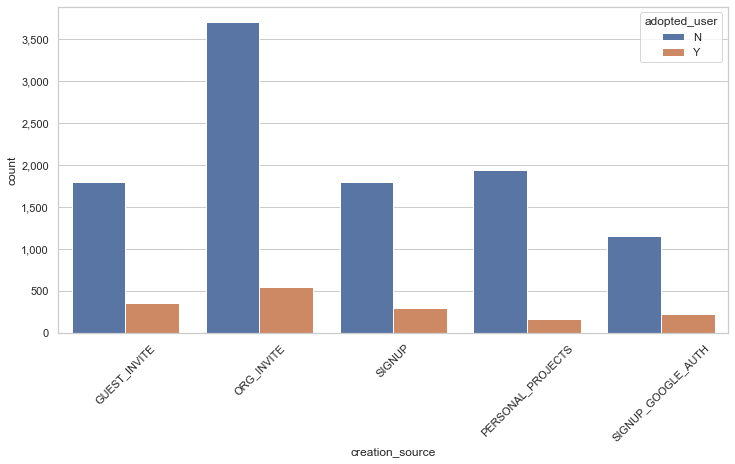

In [17]:
fig, ax = plt.subplots(figsize = (12 , 6))
sns.countplot(x='creation_source', data=dfu, hue='adopted_user');
ax.yaxis.set_major_formatter('{x:,.0f}')
plt.xticks(rotation=45);

Comment: creation_source seems to follow a similar pattern to the overall dataset in terms of adoption rate

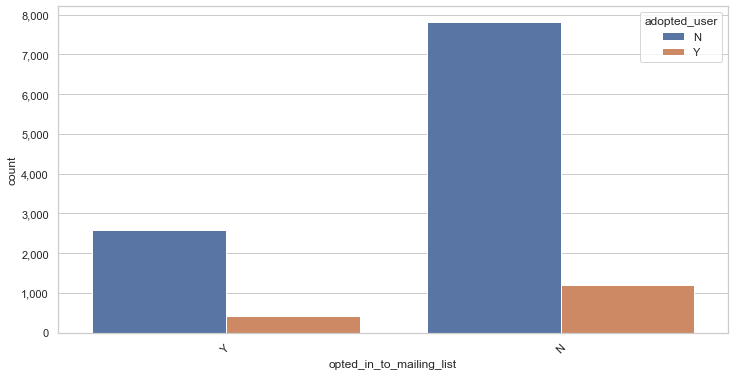

In [18]:
fig, ax = plt.subplots(figsize = (12 , 6))
sns.countplot(x='opted_in_to_mailing_list', data=dfu, hue='adopted_user');
ax.yaxis.set_major_formatter('{x:,.0f}')
plt.xticks(rotation=45);

Comment: users that opted into the mailing list appear to adopt at a higher rate than those that don't opt in.

In [19]:
len(dfu.loc[(dfu['opted_in_to_mailing_list'] == 1)])

0

In [20]:
len(dfu.loc[(dfu['adopted_user'] == 'Y')])

1602

In [21]:
len(dfu.loc[(dfu['adopted_user'] == 'Y') & (dfu['opted_in_to_mailing_list'] == 'Y')])


414

In [22]:
414/2994

0.13827655310621242

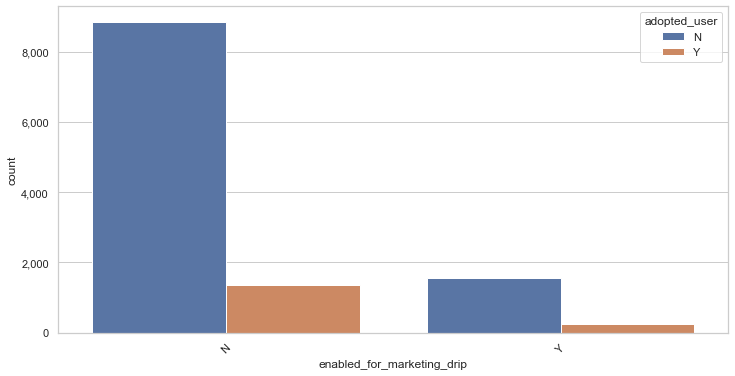

In [23]:
fig, ax = plt.subplots(figsize = (12 , 6))
sns.countplot(x='enabled_for_marketing_drip', data=dfu, hue='adopted_user');
ax.yaxis.set_major_formatter('{x:,.0f}')
plt.xticks(rotation=45);

Comment: users that are enabled for marketing drip appear to adopt at a higher rate

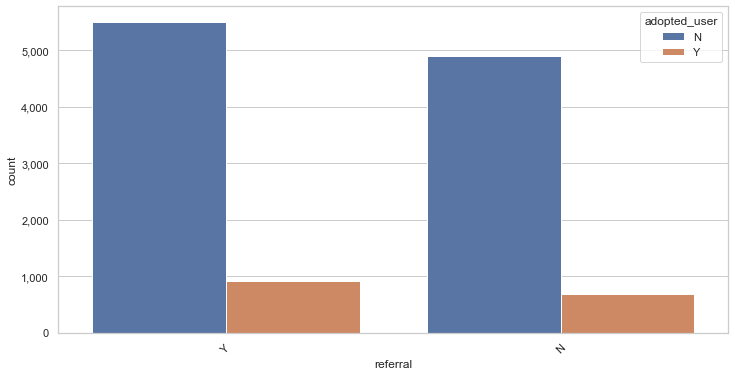

In [24]:
fig, ax = plt.subplots(figsize = (12 , 6))
sns.countplot(x='referral', data=dfu, hue='adopted_user');
ax.yaxis.set_major_formatter('{x:,.0f}')
plt.xticks(rotation=45);

In [25]:
dfu.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,referral
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,"1,398,138,810.0",Y,N,11,"10,803.0",N,Y
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,"1,396,237,504.0",N,N,1,316.0,Y,Y
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,"1,363,734,892.0",N,N,94,"1,525.0",N,Y
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,"1,369,210,168.0",N,N,1,"5,151.0",N,Y
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,"1,358,849,660.0",N,N,193,"5,240.0",N,Y


In [26]:
dfu.dtypes

object_id                       int64
creation_time                  object
name                           object
email                          object
creation_source                object
last_session_creation_time    float64
opted_in_to_mailing_list       object
enabled_for_marketing_drip     object
org_id                          int64
invited_by_user_id            float64
adopted_user                   object
referral                       object
dtype: object

In [27]:
# drop columns that we created to get active status
dfu = dfu.drop(['invited_by_user_id', 'name', 'email', 'object_id', 'creation_time', 'last_session_creation_time'], axis=1)

In [28]:
# opted_in_to_mailing_list, enabled_for_marketing_drip, and org_id should actually all be categorical
dfu["opted_in_to_mailing_list"] = dfu["opted_in_to_mailing_list"].astype(str)
dfu["enabled_for_marketing_drip"] = dfu["enabled_for_marketing_drip"].astype(str)
dfu["org_id"] = dfu["org_id"].astype(str)

In [29]:
# we may need to address that org_id has so many different values
dfu.org_id.value_counts()

0      319
1      233
2      201
3      168
4      159
      ... 
396      9
397      8
400      8
386      7
416      2
Name: org_id, Length: 417, dtype: int64

## <font color='orange'>Modeling</font>

Create dummy variables

In [30]:
# isolate categorical variables
categorical_features = dfu.select_dtypes(include=['object'])

# exclude dependent variable
categorical_features = categorical_features.drop(columns = ['adopted_user'])

dfu2 = pd.concat([dfu.drop(categorical_features, axis=1), pd.get_dummies(categorical_features)], axis=1)

Split data into training and testing subsets

In [31]:
# Create the X and y matrices from the dataframe
X = dfu2.drop(columns = ['adopted_user'])
y = dfu2['adopted_user']

In [32]:
# train_test_split; reserve 20% for test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=23)

In [33]:
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

### Load the datasets

X_train = pd.read_csv('X_train.csv', index_col =[0])
X_test = pd.read_csv('X_test.csv', index_col =[0])
y_train = pd.read_csv('y_train.csv', index_col =[0]) 
y_test = pd.read_csv('y_test.csv', index_col =[0])

In [34]:
eval_set = [(X_train, y_train), (X_test, y_test)]

#### <font color='orange'>Random Forest</font>

In [35]:
# using 3 estimators
rf_clf = RandomForestClassifier(random_state = 23, n_jobs=-1)
rf_clf.fit(X_train, y_train.values.ravel())
y_pred = rf_clf.predict(X_test)

# let's look at classification report
print("Classification Report for Training Data")
print(classification_report(y_train, rf_clf.predict(X_train)))
print("Classification Report for Test Data")
print(classification_report(y_test, rf_clf.predict(X_test)))

Classification Report for Training Data
              precision    recall  f1-score   support

           N       0.91      0.99      0.95      8309
           Y       0.84      0.35      0.49      1291

    accuracy                           0.90      9600
   macro avg       0.87      0.67      0.72      9600
weighted avg       0.90      0.90      0.89      9600

Classification Report for Test Data
              precision    recall  f1-score   support

           N       0.87      0.95      0.91      2089
           Y       0.16      0.06      0.08       311

    accuracy                           0.84      2400
   macro avg       0.51      0.51      0.50      2400
weighted avg       0.78      0.84      0.80      2400



30


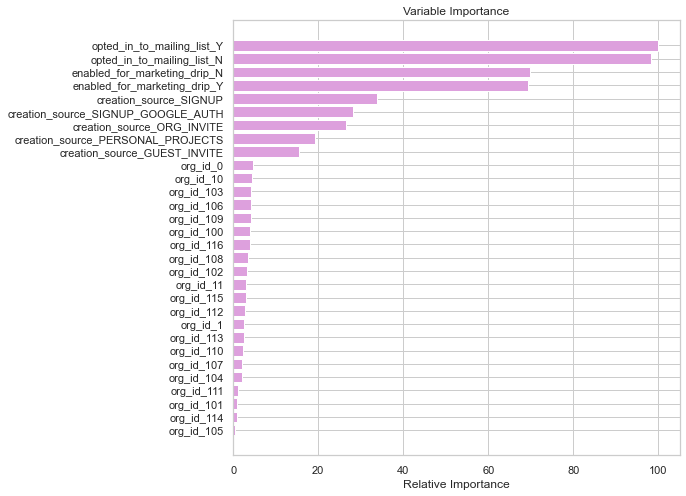

In [36]:
feature_importance = rf_clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(8,8))
plt.barh(pos, feature_importance[sorted_idx], align='center', color = 'plum')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

#### Hyperparameter Tuning- RandomizedSearchCV

In [37]:
# set the parameter grid
param_grid = {
    'n_estimators': [25, 50, 100, 150],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [3, 6, 9],
    'max_leaf_nodes': [3, 6, 9],
}

In [38]:
# comment out to avoid lengthy run
# rf_clf_cv = RandomizedSearchCV(RandomForestClassifier(random_state=23),
#                                    param_grid)
# rf_clf_cv.fit(X_train, y_train.values.ravel())
# print(rf_clf_cv.best_estimator_)

##### Output of above:

1st run
RandomForestClassifier(max_depth=3, max_features='log2', max_leaf_nodes=6,
                       random_state=23)

2nd run





In [39]:
# update with CV
rf_clf_cv = RandomForestClassifier(max_depth=3, max_features='log2', max_leaf_nodes=6, random_state=23)
rf_clf_cv.fit(X_train, y_train.values.ravel())
y_pred = rf_clf_cv.predict(X_test)

# let's look at classification report
print("Classification Report for Training Data")
print(classification_report(y_train, rf_clf_cv.predict(X_train), zero_division=0))
print("Classification Report for Test Data")
print(classification_report(y_test, rf_clf_cv.predict(X_test), zero_division=0))

Classification Report for Training Data
              precision    recall  f1-score   support

           N       0.87      1.00      0.93      8309
           Y       0.00      0.00      0.00      1291

    accuracy                           0.87      9600
   macro avg       0.43      0.50      0.46      9600
weighted avg       0.75      0.87      0.80      9600

Classification Report for Test Data
              precision    recall  f1-score   support

           N       0.87      1.00      0.93      2089
           Y       0.00      0.00      0.00       311

    accuracy                           0.87      2400
   macro avg       0.44      0.50      0.47      2400
weighted avg       0.76      0.87      0.81      2400



30


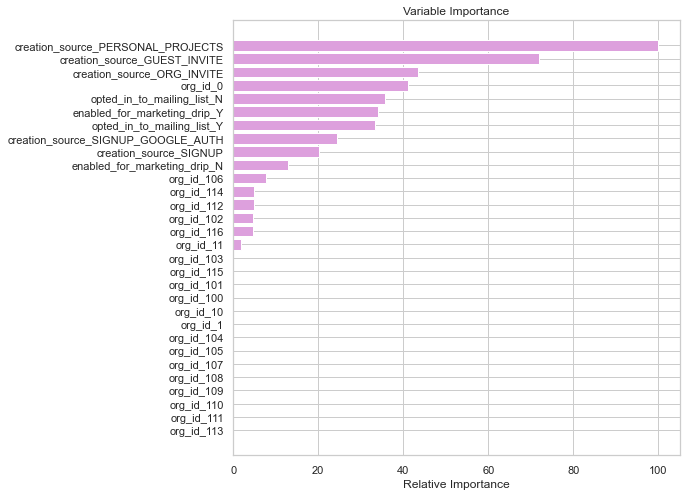

In [40]:
feature_importance = rf_clf_cv.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(8,8))
plt.barh(pos, feature_importance[sorted_idx], align='center', color = 'plum')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

#### <font color='orange'>Light GBM</font>

In [41]:
# define the model
lgbm = LGBMClassifier(random_state=23)
lgbm.fit(X_train, y_train, early_stopping_rounds=20, eval_set=eval_set)

[1]	training's binary_logloss: 0.393285	valid_1's binary_logloss: 0.38469
Training until validation scores don't improve for 20 rounds
[2]	training's binary_logloss: 0.391968	valid_1's binary_logloss: 0.383817
[3]	training's binary_logloss: 0.390854	valid_1's binary_logloss: 0.383158
[4]	training's binary_logloss: 0.389706	valid_1's binary_logloss: 0.382377
[5]	training's binary_logloss: 0.388774	valid_1's binary_logloss: 0.38195
[6]	training's binary_logloss: 0.387984	valid_1's binary_logloss: 0.381519
[7]	training's binary_logloss: 0.387274	valid_1's binary_logloss: 0.381241
[8]	training's binary_logloss: 0.386653	valid_1's binary_logloss: 0.380972
[9]	training's binary_logloss: 0.386007	valid_1's binary_logloss: 0.380762
[10]	training's binary_logloss: 0.385501	valid_1's binary_logloss: 0.38068
[11]	training's binary_logloss: 0.384975	valid_1's binary_logloss: 0.380554
[12]	training's binary_logloss: 0.384466	valid_1's binary_logloss: 0.380392
[13]	training's binary_logloss: 0.38400

LGBMClassifier(random_state=23)

In [42]:
print("Classification Report for Training Data")
print(classification_report(y_train, lgbm.predict(X_train), zero_division=0))
print("Classification Report for Test Data")
print(classification_report(y_test, lgbm.predict(X_test), zero_division=0))

Classification Report for Training Data
              precision    recall  f1-score   support

           N       0.87      1.00      0.93      8309
           Y       0.00      0.00      0.00      1291

    accuracy                           0.87      9600
   macro avg       0.43      0.50      0.46      9600
weighted avg       0.75      0.87      0.80      9600

Classification Report for Test Data
              precision    recall  f1-score   support

           N       0.87      1.00      0.93      2089
           Y       0.00      0.00      0.00       311

    accuracy                           0.87      2400
   macro avg       0.44      0.50      0.47      2400
weighted avg       0.76      0.87      0.81      2400



30


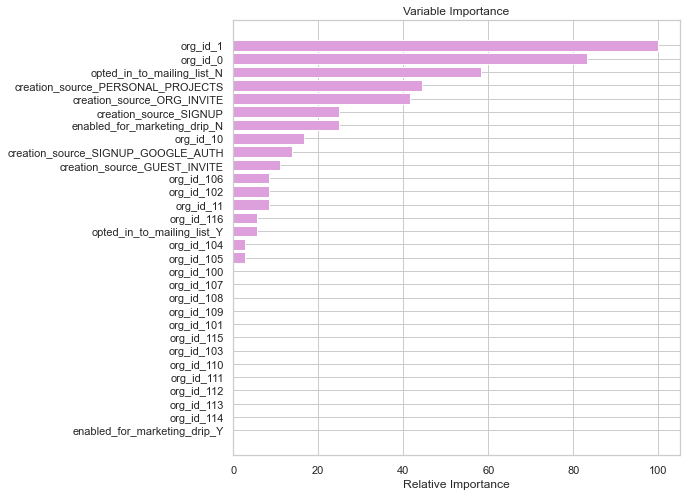

In [43]:
feature_importance = lgbm.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(8,8))
plt.barh(pos, feature_importance[sorted_idx], align='center', color = 'plum')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [44]:
param_grid = {
    'learning_rate': [0.1, 0.3],
    'max_depth': [3, 6, 9],
    'n_estimators': [50, 100, 150],
    'num_leaves': [10, 30, 50],
    'colsample_bytree': [.3, .5, .8]
}

In [45]:
# %%time
# markdown since it takes so long to run
# random_search = RandomizedSearchCV(LGBMClassifier(random_state=23),
#                                    param_grid, n_jobs=-1)
# random_search.fit(X_train, y_train.values.ravel())
# print(random_search.best_estimator_)

Ouput:

1st run: (no session creation time)
LGBMClassifier(colsample_bytree=0.5, learning_rate=0.3, max_depth=3,
               n_estimators=150, num_leaves=30, random_state=23)

2nd run:
LGBMClassifier(colsample_bytree=0.8, learning_rate=0.3, max_depth=6,
               n_estimators=50, num_leaves=50, random_state=23)


In [46]:
# define the model
lgbm = LGBMClassifier(colsample_bytree=0.8, learning_rate=0.3, max_depth=6,
               n_estimators=50, num_leaves=50, random_state=23)
lgbm.fit(X_train, y_train, early_stopping_rounds=20, eval_set=eval_set)

[1]	training's binary_logloss: 0.391694	valid_1's binary_logloss: 0.383703
Training until validation scores don't improve for 20 rounds
[2]	training's binary_logloss: 0.390149	valid_1's binary_logloss: 0.382272
[3]	training's binary_logloss: 0.38874	valid_1's binary_logloss: 0.381401
[4]	training's binary_logloss: 0.387735	valid_1's binary_logloss: 0.380831
[5]	training's binary_logloss: 0.386965	valid_1's binary_logloss: 0.380355
[6]	training's binary_logloss: 0.386334	valid_1's binary_logloss: 0.380587
[7]	training's binary_logloss: 0.385866	valid_1's binary_logloss: 0.380192
[8]	training's binary_logloss: 0.385353	valid_1's binary_logloss: 0.380075
[9]	training's binary_logloss: 0.384868	valid_1's binary_logloss: 0.380785
[10]	training's binary_logloss: 0.384479	valid_1's binary_logloss: 0.380683
[11]	training's binary_logloss: 0.384165	valid_1's binary_logloss: 0.380861
[12]	training's binary_logloss: 0.383811	valid_1's binary_logloss: 0.381009
[13]	training's binary_logloss: 0.383

LGBMClassifier(colsample_bytree=0.8, learning_rate=0.3, max_depth=6,
               n_estimators=50, num_leaves=50, random_state=23)

In [47]:
print("Classification Report for Training Data")
print(classification_report(y_train, lgbm.predict(X_train), zero_division=0))
print("Classification Report for Test Data")
print(classification_report(y_test, lgbm.predict(X_test), zero_division=0))

Classification Report for Training Data
              precision    recall  f1-score   support

           N       0.87      1.00      0.93      8309
           Y       0.00      0.00      0.00      1291

    accuracy                           0.87      9600
   macro avg       0.43      0.50      0.46      9600
weighted avg       0.75      0.87      0.80      9600

Classification Report for Test Data
              precision    recall  f1-score   support

           N       0.87      1.00      0.93      2089
           Y       0.00      0.00      0.00       311

    accuracy                           0.87      2400
   macro avg       0.44      0.50      0.47      2400
weighted avg       0.76      0.87      0.81      2400



30


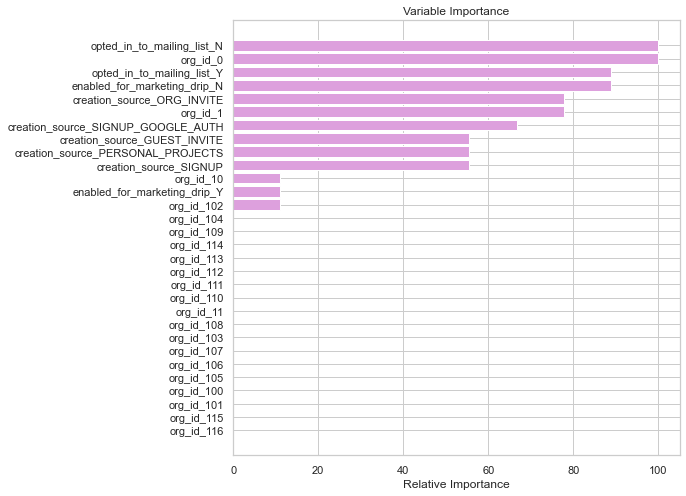

In [48]:
feature_importance = lgbm.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(8,8))
plt.barh(pos, feature_importance[sorted_idx], align='center', color = 'plum')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

## <font color='orange'>Conclusions</font>

- The F1 score of 0.87 for the Random Forest model indicates that this is an effective model for predicting adopted users.
- Creation source - personal projects was an important feature in this model.  This indicates that promoting usage for personal projects could be an effective tactic in driving adoption
- It appears that the mailing list and marketing drip variables were the most important.  It would be wise to attempt to optimize these two channels to boost adoption.

#### write to CSV
from pathlib import Path  
filepath = Path('X_train.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
X_train.to_csv(filepath)

from pathlib import Path  
filepath = Path('X_test.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
X_test.to_csv(filepath)

from pathlib import Path  
filepath = Path('y_train.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
y_train.to_csv(filepath)

from pathlib import Path  
filepath = Path('y_test.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
y_test.to_csv(filepath)